# CSE 5819 Assignment #7

**by: Aayushi Verma (uef24001)**

*due: Sun 11/24/24*

**Part 3 [Programming] (30 pts)**  
**In this assignment you will use Keras to build a recurrent neural network to predict the daily closing price of a stock of your choosing. If you are unsure what to use, you can check out this list on NASDAQ or just use Tesla's stock which has the ticker symbol TSLA.**

In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

**To get stock data, we will use the yfinance library. You can read more about it from https://pypi.org/project/yfinance/ The ticker symbol for Tesla is TSLA. The start date will be January 1, 2016, and the end date will be December 1, 2021. We will use daily prices at Close. If you want to use a different stock, replace TSLA with the appropriate ticker symbol. Split the data into two parts for training and validation. Like training data will be from January 1 2016 to December 31, 2020. The testing data will be from January 1 2021 to December 1 2021.**  

**(4.a) Process the data with either by the MinMaxScaler or StandardScaler (sklearn) to appropriately normalize/standardize the data.**  

In [3]:
# Download Tesla stock data
ticker = 'TSLA'
start_date = '2016-01-01'
end_date = '2021-12-01'

In [4]:
data = yf.download(ticker, start=start_date, end=end_date)
data = data[['Close']]
print(data.columns)

[*********************100%***********************]  1 of 1 completed

MultiIndex([('Close', 'TSLA')],
           names=['Price', 'Ticker'])


In [5]:
# Normalizing the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

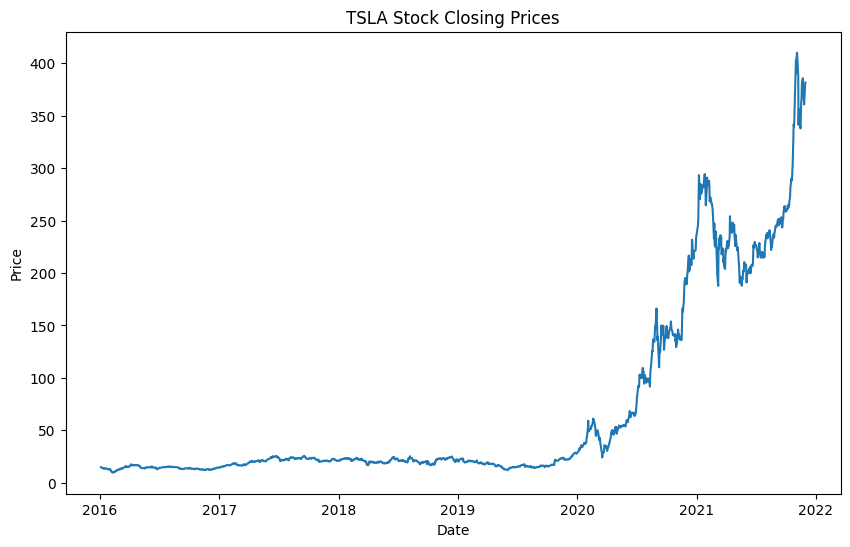

In [6]:
# Plotting the closing prices to visualize the data
plt.figure(figsize=(10, 6))
plt.plot(data['Close'])
plt.title(f'{ticker} Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

**(4.b) Split data into training and testing (this is different from early stratified split. This problem has an autoregressive nature, so you need to get a portion of history data, and use it to train a model that is used to predict later data.)**  

In [7]:
# Split the data into training and test sets
train_data = scaled_data[:len(data) - 252]  # Data from 2016-2020 (252 trading days per year)
test_data = scaled_data[len(data) - 252:]   # Data from 2021-12-01

In [8]:
# Function to create sequences for training LSTM (history of previous 'n' days to predict the next day)
def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])  # history of 'time_step' days
        y.append(data[i, 0])             # the actual value to predict (the next day's closing price)
    return np.array(X), np.array(y)

# Create sequences for training and testing
X_train, y_train = create_sequences(train_data, time_step=60)
X_test, y_test = create_sequences(test_data, time_step=60)

In [9]:
# Reshape the data for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

**(4.c) Create an LSTM model that is trained on the training data and the resultant model will be used to predict the close price in the test data. Use the mean squared error as the loss function, and “Adam” as the optimizer.**  

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [11]:
# Build the LSTM model
model = Sequential()

# Add LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))  # Predicting the next closing price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/20


/Users/aayushi.verma/Documents/GitHub/cse5819-intro-to-ml/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0029 - val_loss: 0.0045
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.6154e-04 - val_loss: 0.0042
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.7343e-04 - val_loss: 0.0032
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.7645e-04 - val_loss: 0.0044
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.7307e-04 - val_loss: 0.0050
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.3844e-04 - val_loss: 0.0028
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.4801e-04 - val_loss: 0.0043
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.8572e-04 - val_loss: 0.0038
Epoch 9/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.4708e-04 - val_loss: 0.0042
Epoch 10/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.8560e-04 - val_loss: 0.0026
Epoch 11/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.8828e-04 - val_loss: 0.0043
Epoch 12/20
37/37 ━━━━━━━━━━━━━━━━

**(4.d) Make predictions (remember to use your scaler to reverse your normalization) and compute RMSE. Plot the prediction curve, and report the RMSE value.**

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Root Mean Squared Error (RMSE): 20.194174789460227


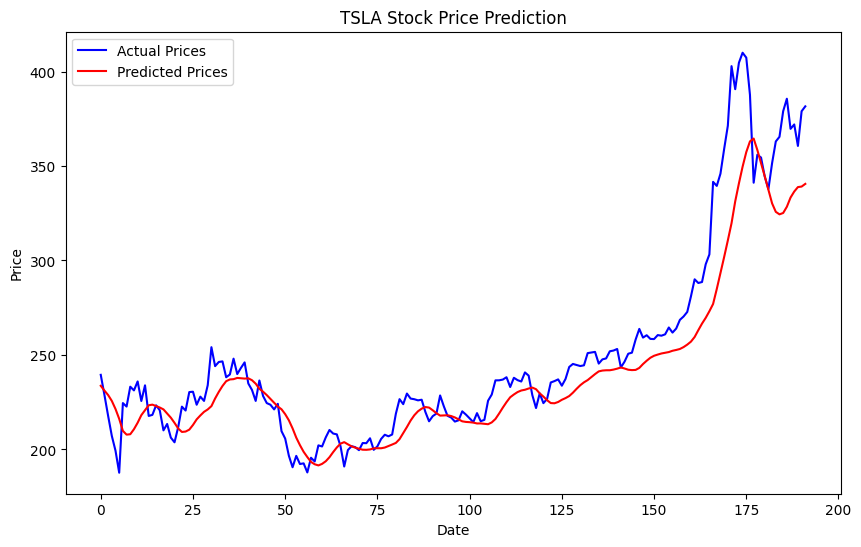

In [12]:
# Make predictions
predictions = model.predict(X_test)

# Invert the scaling
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute RMSE
rmse = np.sqrt(np.mean(np.square(predictions - y_test_actual)))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Plot the predictions vs actual closing prices
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, color='blue', label='Actual Prices')
plt.plot(predictions, color='red', label='Predicted Prices')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()